#   Creating Manual word vectors using Truncated SVD.


 *  Our objective here is to build our own <b> 'Word vector representation to Convert word into a fixed size vectors with Semantic grouping using Truncated SVD</b> based on the words used in the Amazon fine foods review dataset.
 

 *  We are given a 500K datset of reviews from Amazon customers regarding the various food products.
 

 *  After finding the word vectors we will find similar words for a particular word(We use cosine similarity between the vectors)

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import wordcloud
import pickle
import math
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from tqdm import tqdm

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

### Loading data:

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

################################################################################################################################

*****************************************************************************************************************************

<b> I already did several preprocessing on the above dataset to remove HTML tags,stopwords and stored it in a DB file in my laptop.Please refer to the below coding in Github to know more about the preprocessing done. </b>


  Link-https://github.com/Sanatmpa/Machine-Learning/blob/Amazon-Fine-foods-dataset/Amazon%20Fine%20foods-%20Data%20preprocessing.ipynb
      

In [3]:
con=sqlite3.connect('G:\ML\Data_Sets\Amazon\Cleaned_AmazonDB.sqlite')

In [4]:
data=pd.read_sql_query('''Select * from Reviews''',con)

In [5]:
data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak watch realli rosi movi incorp...
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [6]:
data=data.sort_values('Time',axis=0,ascending=True)

In [7]:
data.shape

(364171, 13)

In [8]:
data.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year child sister ...
424,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur star michael keaton...
423,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


#  Building Co-Occurence matrix.

Due to limitation of computational power, I consider only the top 5k words for building co-occurence matrix. We can find the top 5k words from entire dataset by computing their IDF values.

### TF-IDF Vectorization:

In [9]:
tfidf=TfidfVectorizer(dtype='float',min_df=10)
tfidf_train=tfidf.fit_transform(data['New'])

In [9]:
tfidf_train.shape

(364171, 14114)

In [10]:
scaler=StandardScaler(with_mean=False)
std_tfidf_train=scaler.fit_transform(tfidf_train)

In [11]:
idfs=tfidf.idf_
top_5k=idfs.argsort()[:5000]
top_features=list(np.take(tfidf.get_feature_names(),top_5k))

In [12]:
top_features[:5] #Printing top 5 features

['like', 'tast', 'love', 'good', 'great']

### Function to compute co occurence matrix:

In [137]:
from tqdm import tqdm
def Matrix_Co_Oc(feats,document,window=5):
    '''
    Creating co occurence matrix with given features from the input document,that lies within the context window
    '''
    window+=1
    c_matrix=np.zeros((len(feats),len(feats)))
    for review in tqdm(document):
        review_list=[]
        review_list=(review.lower().split()) # Converts each review into a list of words.
        len_rev=len(review_list) # No of words in a review
        #print('\n The review list is ')
        #print(review_list)#print(len_rev)
        for i,words in enumerate(review_list):
            if(words in feats):
                list1=[]
                if(i<=window-1): # When there are not enough context window before a word in a statement
                    list1=[review_list[k] for k in range(0,min(i+window,len_rev-1))]
                    # Used min because some review have length less than 2 * window size.
                elif(i>(len_rev-window)): # When there are not enough context window after a word in a statement
                    list1=[review_list[k] for k in range(i-window+1,len_rev)]
                else:
                    list1=[review_list[k] for k in range(i-window+1,i+window)]
                #print(f'\n List of words in context window on iteration - {i} ,i.e for the word {words.upper()}')
                #print(list1)
                for w in list1:
                    if(w in feats):
                        x_ind=feats.index(words)
                        y_ind=feats.index(w)
                        c_matrix[x_ind,y_ind]+=1 
    np.fill_diagonal(c_matrix,0)
    return c_matrix

### Testing my above written function:

Used the example data from blog 'https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/' 

In [136]:
Corpus = ['He is not lazy He is intelligent He is smart','TMP ']
features=['he','is','not','lazy','intelligent','smart']
mat1=Matrix_Co_Oc(features,Corpus,2)
print(mat1)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]


 The review list is 
['he', 'is', 'not', 'lazy', 'he', 'is', 'intelligent', 'he', 'is', 'smart']

 List of words in context window on iteration - 0 ,i.e for the word HE
['he', 'is', 'not']

 List of words in context window on iteration - 1 ,i.e for the word IS
['he', 'is', 'not', 'lazy']

 List of words in context window on iteration - 2 ,i.e for the word NOT
['he', 'is', 'not', 'lazy', 'he']

 List of words in context window on iteration - 3 ,i.e for the word LAZY
['is', 'not', 'lazy', 'he', 'is']

 List of words in context window on iteration - 4 ,i.e for the word HE
['not', 'lazy', 'he', 'is', 'intelligent']

 List of words in context window on iteration - 5 ,i.e for the word IS
['lazy', 'he', 'is', 'intelligent', 'he']

 List of words in context window on iteration - 6 ,i.e for the word INTELLIGENT
['he', 'is', 'intelligent', 'he', 'is']

 List of words in context window on iteration - 7 ,i.e for the word HE
['is', 'intelligent', 'he', 'is', 'smart']

 List of words in context win

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 41.68it/s]


[[0. 4. 2. 1. 2. 1.]
 [4. 0. 1. 2. 2. 1.]
 [2. 1. 0. 1. 0. 0.]
 [1. 2. 1. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]]


So the output is generated perfectly as theoretically explained in the blog.

### Implementing Co occurence matrix:

Let us compute cooccurence matrix for top 5k words using first 100k reviews.

In [14]:
Coocc_Mat = Matrix_Co_Oc(top_features,data['New'][:100000].values,5)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [40:27<00:00, 30.13it/s]


In [9]:
with open(r'G:\ML\Pickles\Co_occ_50k.pickle','rb') as f:
    Coocc_Mat,top_features=pickle.load(f)

In [15]:
Coocc_Mat.shape

(5000, 5000)

# Applying Truncated SVD.

Let us apply truncated SVD on the Cooccurence matrix that was obtained to find the word vector of each words, in the reduced dimension.

First we need to find the number of dimensions(K) in truncated SVD that can explain maximum information about the words of dimension(N) where <b> K < N </b> .

### Function to find variance explained:

In [18]:
def component_variance(x,n):
    svd=TruncatedSVD(n_components = n, random_state=33)
    model=svd.fit(x)
    com_var=model.explained_variance_ratio_
    cum_var=[]
    var=0
    for i in com_var:
        var+=i
        cum_var.append(var)
    return cum_var        

In [19]:
var=component_variance(Coocc_Mat,3500)

Text(0,0.5,'Variance explained -> ')

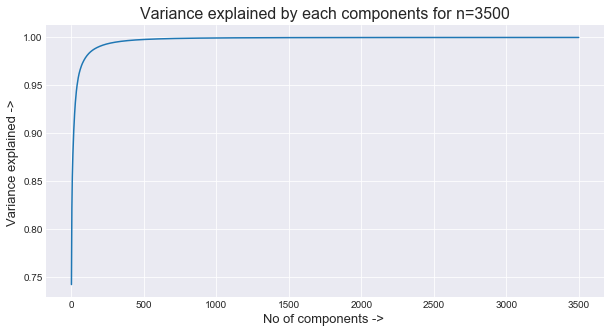

In [36]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
plt.plot(var)
plt.title('Variance explained by each components for n=3500',fontsize=16)
plt.xlabel('No of components -> ',fontsize=13)
plt.ylabel('Variance explained -> ',fontsize=13)

Since the variance reached much closer to 1 at around dimension 500, we will zoom deep to get better value of dimesnion to be chosen.

Text(0,0.5,'Variance explained -> ')

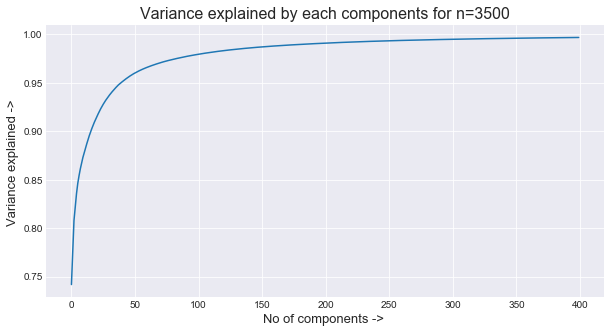

In [37]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
plt.plot(var[:400])
plt.title('Variance explained by each components for n=3500',fontsize=16)
plt.xlabel('No of components -> ',fontsize=13)
plt.ylabel('Variance explained -> ',fontsize=13)

In [44]:
print(var[200])
print(var[250])
print(var[275])
print(var[300])
print(var[300])
print(var[320])
print(var[350])
print(var[375])
print(var[400])

0.9910387878525333
0.9934505740053948
0.994305984745023
0.9950126257469408
0.9950126257469408
0.9954934105828249
0.9961010150430812
0.9965232461420286
0.9968839764396422


So at no of components around 300, almost of the variance is explained. Hence <b> No of dimensions of wordvector can be chosen as 300</b>.

### Implementing Word vectors:

In [19]:
svd=TruncatedSVD(n_components=300,random_state=33)
word_vectors=svd.fit_transform(Coocc_Mat)

In [11]:
with open(r'G:\ML\Pickles\word_vectors_ex10.pickle','rb') as f:
    word_vectors= pickle.load(f)

So we finally created a 300d vector representation for the most used words in the top 100K reviews.

# K Means clustering

Lets cluster the word embeddings obtained from our model to see how well relavant words got grouped.

### Function to calculate optimal K :

In [48]:
def optimal_k(x,k=[5,10,20,35,50,65,80]):
    '''
    Function to find optimal value of K
    '''
    list_inertia=[]
    for i in k:
        km=KMeans(n_clusters=i,init='k-means++',n_init=5,random_state=33)
        km.fit(x)
        list_inertia.append(km.inertia_)
        print(f'\n For K value ={i} and inertia is {km.inertia_}')
    plt.figure(figsize=(10,5))
    sns.set_style('darkgrid')
    plt.plot(k,list_inertia)   
    plt.xlabel('K values --> ')
    plt.ylabel('Errors+''('+'Inertia'+')'+'-->')
    plt.title('Variation in K with loss')
    #plt.legend()
    plt.show() 

### Word cloud builder for a cluster:

In [144]:
def cloud(df,cluster):
    '''
    To print wordcloud of a cluster with inputs as Dataframe and Cluster number.
    '''
    wc=WordCloud(width=1500,height=1000,background_color='black').generate(' '.join(df.words[df['Cluster']==cluster]))
    plt.figure(figsize=(12,5))
    plt.imshow(wc)
    plt.axis('off')

### Finding optimal value of K :


 For K value =5 and inertia is 1601844715.3897865

 For K value =10 and inertia is 1169115006.2354655

 For K value =20 and inertia is 893796700.8493943

 For K value =35 and inertia is 665122895.5421225

 For K value =50 and inertia is 515713080.27331406

 For K value =65 and inertia is 428661057.66393554

 For K value =80 and inertia is 363518868.7356767


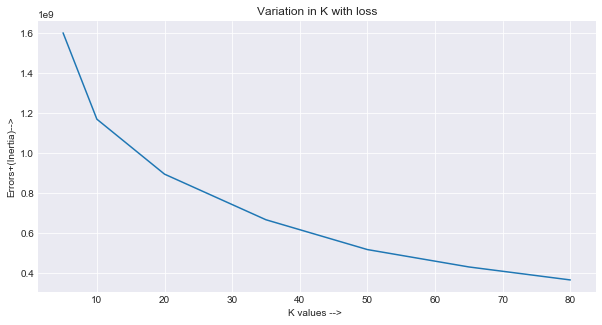

In [49]:
optimal_k(word_vectors)

### Implementation:

In [138]:
KM=KMeans(n_clusters=10,init='k-means++',n_init=10,random_state=33)

In [139]:
KM.fit(word_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=33, tol=0.0001, verbose=0)

In [141]:
lb=KM.labels_
pd.value_counts(lb)

1    4141
7     522
0     174
4      81
3      51
6      19
2       9
9       1
5       1
8       1
dtype: int64

In [142]:
tmp=top_features
tmp=pd.DataFrame(tmp,columns=['words'])
tmp['Cluster']=lb
tmp.Cluster.value_counts()

1    4141
7     522
0     174
4      81
3      51
6      19
2       9
9       1
5       1
8       1
Name: Cluster, dtype: int64

In [64]:
tmp.head()

,words,Cluster
0,like,9
1,tast,5
2,love,2
3,good,2
4,great,2


#### Analysing Clusters:

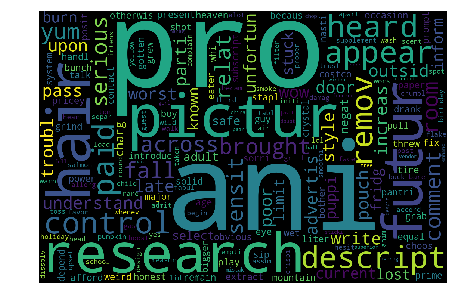

In [36]:
cloud(tmp,1)

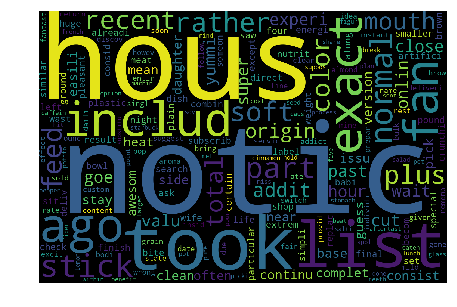

In [37]:
cloud(tmp,7)

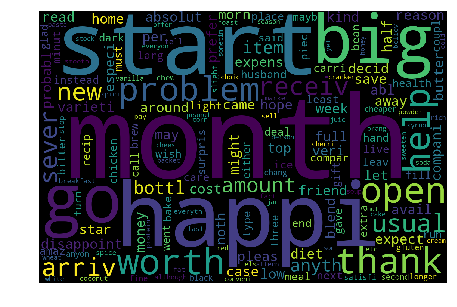

In [38]:
cloud(tmp,0)

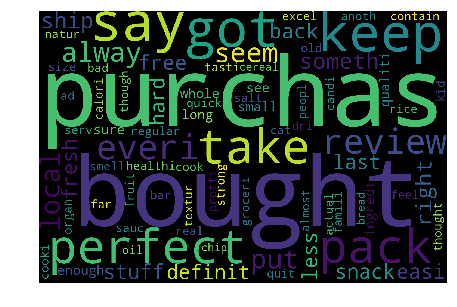

In [39]:
cloud(tmp,4)

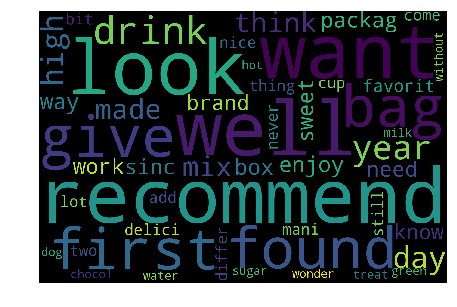

In [145]:
cloud(tmp,3)

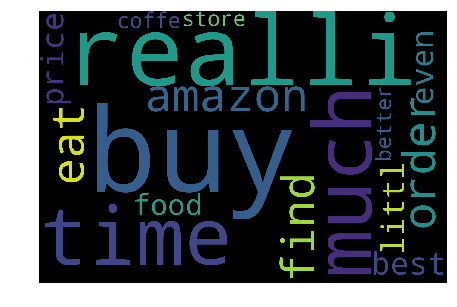

In [35]:
cloud(tmp,6)

<b> From consolidating the above word clouds, we can say that its better clustered, cluster 4 speaks about purchase,bought etc. Cluster 3 contains reviews about reccomendation and what went well. Cluster 6 contains many positive words etc,Cluster 0 contains words like start,month and etc.

# Finding similar vectors 

So far the word vector that we built seems to be working good.

There is also an objective for us to embed them with semantic meanings. Lets see how good our vector representation can provide meaningful similar words.

### Function to calculate Cosine similarity b/w words:

In [148]:
from sklearn.metrics.pairwise import cosine_similarity
def similar(w,n=2):
    if(w in top_features):
        index=top_features.index(w)
        cos_sim=np.zeros(len(top_features))
        for i in range(0,len(top_features)):
            if i==index:
                continue
            else:
                cos_sim[i]=cosine_similarity([word_vectors[index]],[word_vectors[i]])
        cos_sim_index=cos_sim.argsort()[::-1][:n]
        print(f'\n {n} Similar words for {w.upper()} are : ')
        for i in cos_sim_index:
            print(f'\n -> {top_features[i].upper()}   -   {cos_sim[i].round(5)} ') 
    else:
        print('\n Entered word is not present in co-occurence matrix')
        

In [149]:
similar('great',4)


 4 Similar words for GREAT are : 

 -> AWESOM   -   0.95153 

 -> FANTAST   -   0.94722 

 -> AMAZ   -   0.94368 

 -> GOOD   -   0.94159 


In [150]:
similar('tasti',5)


 5 Similar words for TASTI are : 

 -> YUMMI   -   0.94279 

 -> DELICI   -   0.93329 

 -> COURS   -   0.91952 

 -> ALSO   -   0.91747 

 -> ESPECI   -   0.91099 


In [151]:
similar('tea')


 2 Similar words for TEA are : 

 -> COFFE   -   0.83938 

 -> EITHER   -   0.80992 


In [152]:
similar('dog',3)


 3 Similar words for DOG are : 

 -> PUP   -   0.90069 

 -> CAT   -   0.88813 

 -> PUPPI   -   0.88707 


In [153]:
similar('bad',3)


 3 Similar words for BAD are : 

 -> ACTUAL   -   0.95493 

 -> SUPPOS   -   0.94716 

 -> OKAY   -   0.93905 


#### <i> From the above observations, It is clear that the words are getting grouped sematically and our word vector representation has done a good job with 300d representation for each words.

# Benchmark with Word2vec 

Since every new model needs some benchmark test with an existing well performing model. Here we consider one of the best state of the art model for semantic word embedding that was provided by Google called Word2Vec. It is available in gensim package.

In [88]:
review_list=[]
for review in tqdm(data['New'][:100000]):
    review_list.append(review.split())

100%|██████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 108746.48it/s]


In [89]:
review_list[5]

['one', 'movi', 'movi', 'collect', 'fill', 'whatev', 'els', 'want', 'call']

We will create similar 300d representation using the W2V model.

In [97]:
w2v_model=Word2Vec(review_list,size=300,min_count=10,window=5)

In [98]:
w2v_list=list(w2v_model.wv.vocab)
len(w2v_list)

8578

No of words that appeared more than 10 times in top 100k reviews = 8578.

********************************************************************************************************************************

Since we built the word2vec model, its time for us to test some word embedding to compare the performance of both the models.

In [99]:
w2v_model.wv.most_similar('great')

[('excel', 0.7464737296104431),
 ('fantast', 0.7058613300323486),
 ('terrif', 0.7049163579940796),
 ('wonder', 0.6642613410949707),
 ('good', 0.6376404762268066),
 ('awesom', 0.6364843249320984),
 ('nice', 0.5959254503250122),
 ('perfect', 0.5482356548309326),
 ('fabul', 0.5127210021018982),
 ('outstand', 0.4922030568122864)]

In [100]:
w2v_model.wv.most_similar('tasti')

[('yummi', 0.6634608507156372),
 ('delici', 0.6543010473251343),
 ('tastey', 0.5326657295227051),
 ('hearti', 0.5316096544265747),
 ('nutriti', 0.5121549367904663),
 ('satisfi', 0.5107212662696838),
 ('good', 0.4827163815498352),
 ('dens', 0.4741671681404114),
 ('nice', 0.4659765362739563),
 ('versatil', 0.45128265023231506)]

In [102]:
w2v_model.wv.most_similar('dog')

[('puppi', 0.8152056932449341),
 ('pup', 0.7803576588630676),
 ('chihuahua', 0.7417277693748474),
 ('doggi', 0.7343426942825317),
 ('greeni', 0.7324253916740417),
 ('cat', 0.7264014482498169),
 ('yorki', 0.7249447107315063),
 ('poodl', 0.7093725204467773),
 ('kibbl', 0.6982234716415405),
 ('merrick', 0.6957718133926392)]

In [101]:
w2v_model.wv.most_similar('tea')

[('twine', 0.7142293453216553),
 ('jasmin', 0.7108528017997742),
 ('rooibo', 0.701972484588623),
 ('oolong', 0.6992292404174805),
 ('bigelow', 0.691969633102417),
 ('herbal', 0.6877332329750061),
 ('numi', 0.6873214244842529),
 ('teabag', 0.6869863271713257),
 ('tetley', 0.6748582124710083),
 ('lipton', 0.6685627102851868)]

# Conclusion

From above few examples, we can see that for the words like, tasti,dog, the model that we created provided almost similar results and for some words like tea there is no great predictions from our model. But on comparision, the model that we created is just from the cooccurence matrix of top 5k words used in reviews whereas the word2vec model is much well versed, it has a shallow neural network like architecture and it was trained with words in the top 100k features..